In [1]:
! conda install pytorch-nightly -c pytorch --yes

Solving environment: done

## Package Plan ##

  environment location: /Users/abhinavverma/anaconda3

  added / updated specs:
    - pytorch-nightly


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.11               |           py37_0         1.7 MB
    ninja-1.9.0                |   py37h04f5b5a_0          96 KB
    pytorch-nightly-1.0.0.dev20190405|          py3.7_0        47.7 MB  pytorch
    ------------------------------------------------------------
                                           Total:        49.5 MB

The following NEW packages will be INSTALLED:

  ninja              pkgs/main/osx-64::ninja-1.9.0-py37h04f5b5a_0
  pytorch-nightly    pytorch/osx-64::pytorch-nightly-1.0.0.dev20190405-py3.7_0

The following packages will be UPDATED:

  conda                                        4.6.8-py37_0 --> 4.6.11-py37_0



pytorch-nightly-1.0. | 47.7 MB   | ##############

In [1]:
! conda uninstall --force pytorch


PackagesNotFoundError: The following packages are missing from the target environment:
  - pytorch




In [1]:
import torch
from exp.nb_Training import *

In [8]:
from fastai import datasets
from time import sleep

In [21]:
class SlowCalculator():
    def __init__(self, cb=None): self.cb,self.res = cb,0
    
    def __call__(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb,cb_name, None)
        if cb: return cb(self,*args) #self stands for the instance of SlowCalculator()

    def calc(self):
        for i in range(5):
            self('before_calc', i)
            self.res += i*i
            sleep(1)
            if self('after_calc', i):
                print("stopping early")
                break

In [22]:
class ModifyingCallback():
    def after_calc (self, calc, epoch):
        print(type(calc))
        print(f"After {epoch}: {calc.res}")
        if calc.res>10: return True
        if calc.res<3: calc.res = calc.res*2

In [23]:
calculator = SlowCalculator(ModifyingCallback())

In [24]:
calculator.calc()

<class '__main__.SlowCalculator'>
After 0: 0
<class '__main__.SlowCalculator'>
After 1: 1
<class '__main__.SlowCalculator'>
After 2: 6
<class '__main__.SlowCalculator'>
After 3: 15
stopping early


In [25]:
torch.get_num_threads()

2

In [2]:
from pathlib import Path
import gzip,pickle
from torch import tensor

In [5]:
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

In [3]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))
def normalize(x,m,s):
    return (x-m)/s

In [6]:
x_train,y_train,x_valid,y_valid = get_data()

In [7]:
train_mean,train_std = x_train.mean(),x_train.std()

In [8]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [9]:
x_train,x_valid = normalize_to(x_train,x_valid)

In [10]:
#completely generic function to change the size of the input vector to the size we want
def view_tfm(*size):
    print(*size)
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [11]:
inner = view_tfm(1,28,28)

1 28 28


In [50]:
??torch.nn.Module

In [12]:
x_train.shape

torch.Size([50000, 784])

In [13]:
inner(x_train).shape

torch.Size([50000, 1, 28, 28])

### Let's create a simple CNN learner layer fit

In [14]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [15]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy
bs = 64

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [16]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [17]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [18]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [19]:
model = get_cnn_model(data)

In [20]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [21]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(1, learn)

train: [0.402578828125, tensor(0.8687)]
valid: [0.383096044921875, tensor(0.9036)]
CPU times: user 20.2 s, sys: 2.89 s, total: 23.1 s
Wall time: 7.88 s


The Mac is very slow

In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [24]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [25]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [26]:
cbfs

[exp.nb_Training.Recorder,
 functools.partial(<class 'exp.nb_Training.AvgStatsCallback'>, <function accuracy at 0x1a28961268>),
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x1a2895b378>)]

In [27]:
nfs = [8,16,32,32]

In [29]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [30]:
get_cnn_layers(data,nfs)

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), AdaptiveAvgPool2d(output_size=1), Lambda(), Linear(in_features=32, out_features=10, bias=True)]

In [31]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [32]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [33]:
learn1,run1 = get_runner(model, data, lr=0.4, cbs=cbfs)

In [34]:
%time run.fit(3, learn)

train: [0.469774453125, tensor(0.8426)]
valid: [0.1129917724609375, tensor(0.9672)]
train: [0.09288205078125, tensor(0.9717)]
valid: [0.09296600952148437, tensor(0.9713)]
train: [0.0712677978515625, tensor(0.9770)]
valid: [0.3370674560546875, tensor(0.9073)]
CPU times: user 1min, sys: 9.13 s, total: 1min 10s
Wall time: 24.4 s



### Hooks

Manual insertion
Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:



In [35]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [38]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [39]:
run.fit(2, learn)

train: [0.786791953125, tensor(0.7302)]
valid: [0.15049937744140626, tensor(0.9586)]
train: [0.13554908203125, tensor(0.9586)]
valid: [1.181319140625, tensor(0.7073)]


In [44]:
len(model.act_means[0])

1722

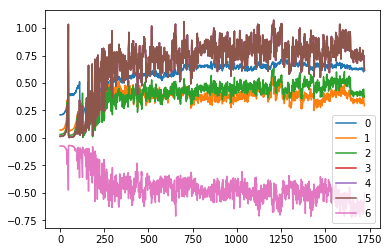

In [46]:
for l in model.act_means: plt.plot(l)
plt.legend(range(7));

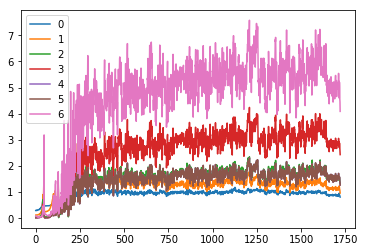

In [48]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(7));

## Pytorch calls the callbacks which returns the activation and data of each individual layers as hooks. They are registered using register forward and register backward methods

In [49]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [50]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [51]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [52]:
run.fit(1, learn)

train: [0.4058405078125, tensor(0.8634)]
valid: [0.14798011474609374, tensor(0.9546)]


In [55]:
dir(hooks[0])

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'hook',
 'remove',
 'stats']

In [57]:
hooks[0].stats

([tensor(0.1440),
  tensor(0.1425),
  tensor(0.1452),
  tensor(0.1498),
  tensor(0.1438),
  tensor(0.1391),
  tensor(0.1446),
  tensor(0.1426),
  tensor(0.1429),
  tensor(0.1472),
  tensor(0.1476),
  tensor(0.1502),
  tensor(0.1512),
  tensor(0.1467),
  tensor(0.1564),
  tensor(0.1537),
  tensor(0.1481),
  tensor(0.1482),
  tensor(0.1613),
  tensor(0.1638),
  tensor(0.1585),
  tensor(0.1549),
  tensor(0.1725),
  tensor(0.1644),
  tensor(0.1679),
  tensor(0.1671),
  tensor(0.1749),
  tensor(0.1762),
  tensor(0.1818),
  tensor(0.1807),
  tensor(0.1924),
  tensor(0.1903),
  tensor(0.2027),
  tensor(0.2138),
  tensor(0.2153),
  tensor(0.2429),
  tensor(0.2640),
  tensor(0.2780),
  tensor(0.3257),
  tensor(0.3422),
  tensor(0.3360),
  tensor(0.3274),
  tensor(0.3904),
  tensor(0.4546),
  tensor(0.4474),
  tensor(0.2714),
  tensor(0.2984),
  tensor(0.3159),
  tensor(0.3215),
  tensor(0.3853),
  tensor(0.3231),
  tensor(0.3856),
  tensor(0.3985),
  tensor(0.5101),
  tensor(0.4751),
  tensor(0

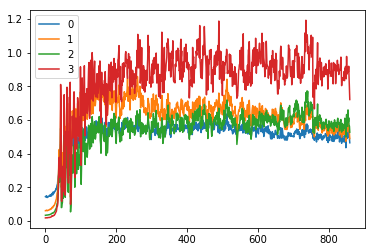

In [58]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

##### A Hooks class


Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:

a single index
a slice (like 1:5)
a list of indices
a mask of indices ([True,False,False,True,...])
The __iter__ method is there to be able to do things like for x in ....

In [59]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [60]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

We can use it to write a Hooks class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [61]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [63]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [64]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x1a296bef28>, <__main__.Hook object at 0x1a29a22b70>, <__main__.Hook object at 0x1a29a229e8>, <__main__.Hook object at 0x1a29a22a58>, <__main__.Hook object at 0x1a29a22a20>, <__main__.Hook object at 0x1a29a22630>, <__main__.Hook object at 0x1a29a22d68>]

In [65]:
hooks.remove()

In [66]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x)

In [67]:
x.mean(),x.std()

(tensor(0.0158), tensor(1.0156))

In [68]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2704, grad_fn=<MeanBackward0>),
 tensor(0.4563, grad_fn=<StdBackward0>))

In [71]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [72]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4587, grad_fn=<MeanBackward0>),
 tensor(1.0433, grad_fn=<StdBackward0>))

train: [0.4413724609375, tensor(0.8568)]
valid: [0.12334254150390625, tensor(0.9630)]
train: [0.11845736328125, tensor(0.9645)]
valid: [0.149633935546875, tensor(0.9544)]


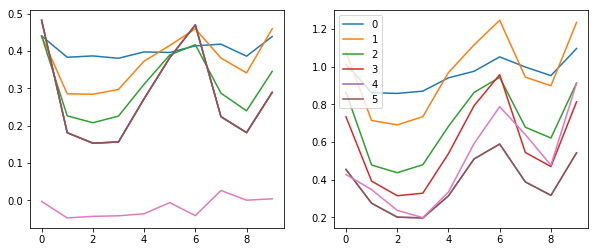

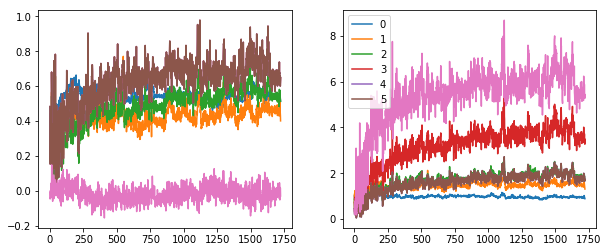

In [73]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [80]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [82]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [83]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [85]:
with Hooks(model, append_stats) as hooks_1: run.fit(1, learn)

train: [0.127595205078125, tensor(0.9634)]
valid: [0.10609920654296875, tensor(0.9698)]


In [86]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

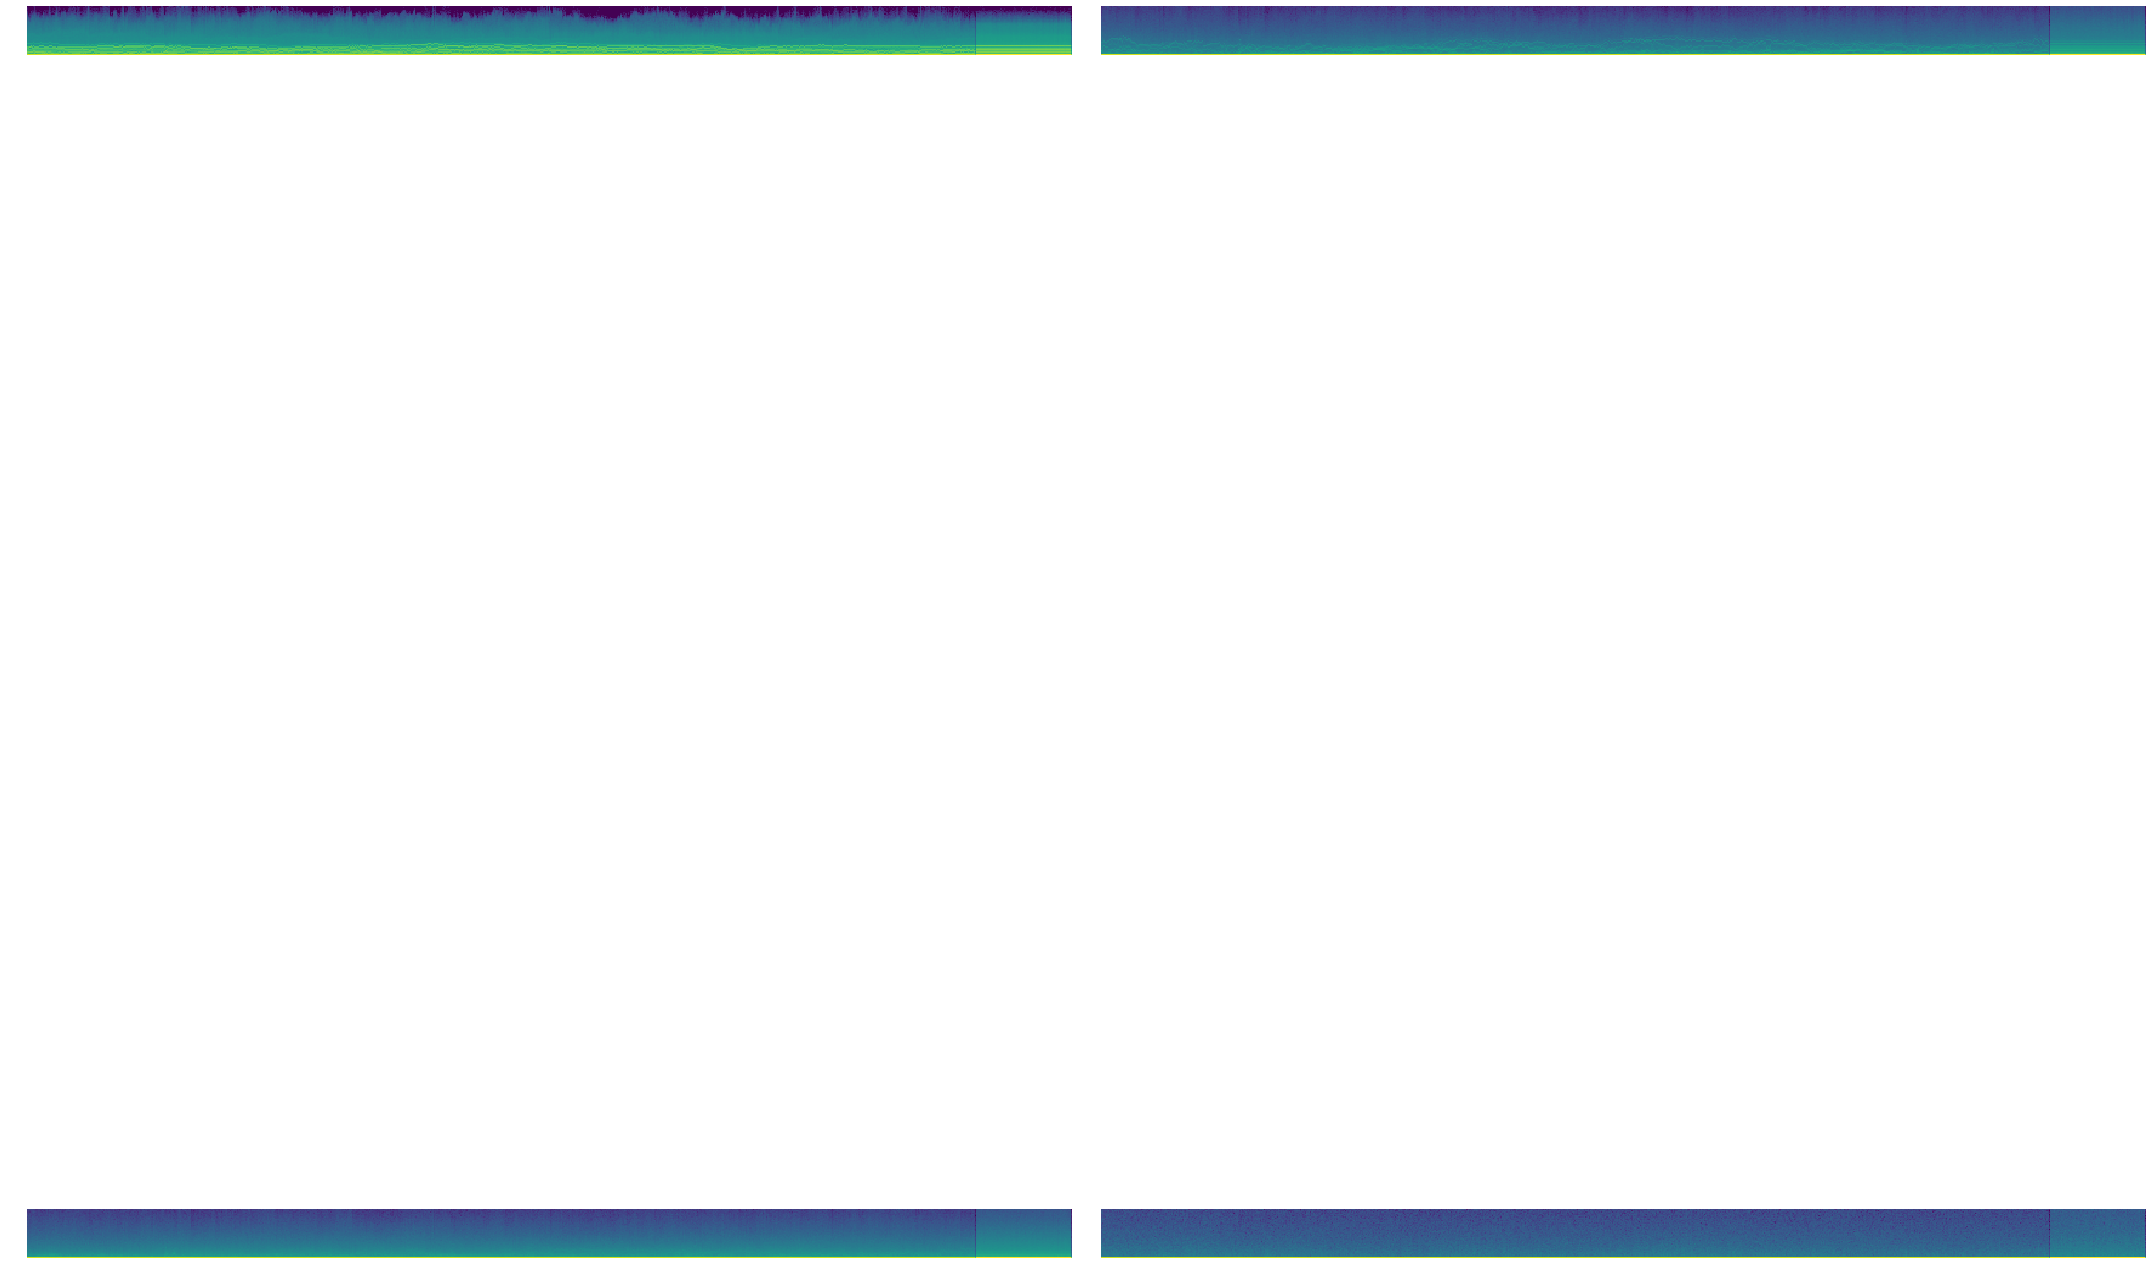

In [91]:
fig,axes = plt.subplots(2,2, figsize=(30,50))
for ax,h in zip(axes.flatten(), hooks_1[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [92]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

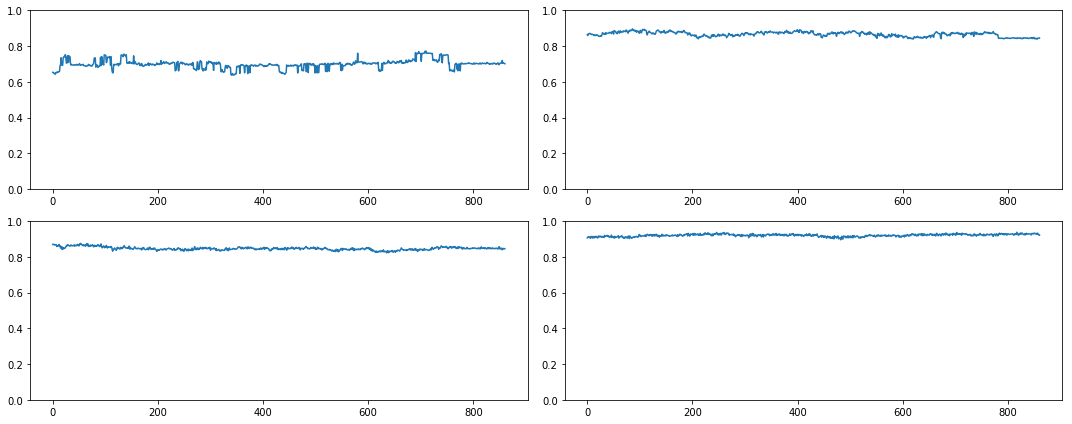

In [93]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks_1[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

TypeError: object of type 'Hook' has no len()